In [2]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");

v3.1


v3.0


v2.1


In [44]:
# parameters
Pe = 7.5;
initial_Δ = 1e-5;
max_iter = 60;
tol = 1e-12;
atol = 1e-14;
rho_max = (1-1e-20);
#quick solve
Pe = 7.5;
γ_limit = find_gamma_limit(;Pe = Pe, initial_Δ = initial_Δ, γ_max = 100.)
#set Γ range
Γ = collect(1:0.01:γ_limit)
for i in 4:1:10
    γ1 = round(γ_limit, RoundDown; digits= i-2)
    γ2 = round(γ_limit, RoundDown; digits= i)
    Γ = append!(Γ,collect(γ1:(10.0^(-i)):γ2))
end
# println(Γ)
#solve over Γ
Pes = []
    γs = []
    ϕ1s = []
    ϕ2s = []
    approx = []
    errors = []
for γ in Γ
    find_sol = false
    try 
        find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol)
        if find_sol
            push!(ϕ1s,lower_limits[1])
            push!(ϕ2s,upper_limits[1])
            push!(γs, γ)
        end
    catch
            println("no solution Pe=$(Pe), γ=$(γ)")
            push!(errors,γ)
    end
end
average_ϕs = (ϕ1s+ ϕ2s)./2
χs = chis_converter(γs, average_ϕs)

#save results
using JLD2
    data = Dict{String,Any}()
    @pack! data = Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs
    filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
    wsave(filename,data)


no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776


no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in g0
no solution Pe=7.5, γ=2.2104681138915776
no turn in

27-element Vector{Any}:
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 ⋮
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776
 2.2104681138915776

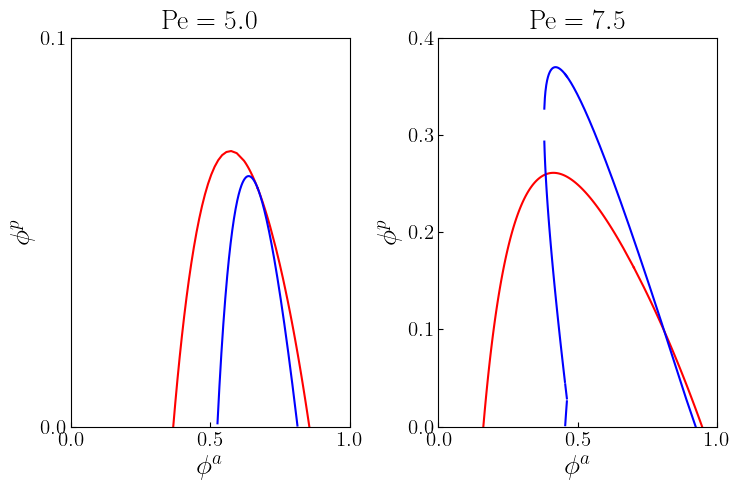

In [147]:
Pes = [5.0, 7.5]
axlims = [[0.0, 1.0, 0, 0.1], [0.0, 1.0, 0, 0.4]]
using PyPlot
PyPlot.close("all")
rc("text", usetex=true)
fig, axs = plt.subplots(1,2, figsize=(7.5,5))
for (ax, Pe, axlim) in zip(axs, Pes, axlims)
    # load binodal
        filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
        data = wload(filename)
        @unpack Pe, γs, ϕ1s, ϕ2s = data

    # plot binodal
        binod = ax.plot(gammas_converter_a(γs, ϕ1s), gammas_converter_p(γs, ϕ1s), color = "red", label = "Binodal")
        ax.plot(gammas_converter_a(γs, ϕ2s), gammas_converter_p(γs, ϕ2s), color = "red", label = "_Bindoal")
        #ax.plot(0.:0.1:1., 1.:-0.1:0., color = "black", label = "_Full")

        rc("text", usetex=true)
        ax.xaxis.set_ticks(0.:0.5:1.0)
        ax.yaxis.set_ticks(0.:0.1:0.4)
        ax.axis(axlim)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.xaxis.tick_bottom()
        ax.yaxis.set_tick_params(labelsize=15)
        
        #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
        ax.set_xlabel(L"\phi^a",fontsize=20)
        ax.set_ylabel(L"\phi^p", fontsize=20)
        # ax.legend(loc = "upper right", fontsize=20)
        # ax.set_aspect(0.25*Δρ/ΔPe)
        title = latexstring("\$ \\mathrm{Pe} = $(Pe)\$")
        ax.set_title(title,fontsize=20)
        ax.tick_params(labelbottom = true, direction = "in")
    #
    # plot spinodal
        ϕas = collect(0.001:0.001:0.999)
        # ϕa_sols, low_ϕps, high_ϕps = return_complex_boundary_outer(ϕas; Pe = Pe)
        # n = length([x for x in ϕa_sols if x < 0.42])
        # N = length(ϕa_sols)
        # ax.plot(ϕa_sols[1:n], low_ϕps[1:n], color = "green", label = "Complex")
        # ax.plot(ϕa_sols[1:n], high_ϕps[1:n], color = "green", label = "_Complex")
        # ax.plot(ϕa_sols[(n+1):1:N], low_ϕps[(n+1):1:N], color = "green", label = "_Complex")
        # ax.plot(ϕa_sols[(n+1):1:N], high_ϕps[(n+1):1:N], color = "green", label = "_Complex")


        # ϕa_sols, low_ϕps1, high_ϕps1, low_ϕps2, high_ϕps2 = return_complex_boundary_inner(ϕas; Pe = Pe)
        # ax.plot(ϕa_sols, low_ϕps1, color = "green", label = "_Complex")
        # ax.plot(ϕa_sols, high_ϕps1, color = "green", label = "_Complex")
        # ax.plot(ϕa_sols, low_ϕps2, color = "green", label = "_Complex")
        # ax.plot(ϕa_sols, high_ϕps2, color = "green", label = "_Complex")

        ϕa_low, ϕa_high, low_ϕps2, high_ϕps2 = return_stable_boundary(ϕas; Pe = Pe)
        ax.plot(ϕa_low, low_ϕps2, color = "blue", label = "Spinodal", linestyle = "-")
        ax.plot(ϕa_high, high_ϕps2, color = "blue", label = "_Spindoal", linestyle = "-")

        ϕa_low, ϕa_mid, ϕa_high, low_ϕps, mid_ϕps, high_ϕps = return_stable_boundary_extra(ϕas; Pe = Pe)
        ax.plot(ϕa_low, low_ϕps, color = "blue", label = "_Spinodal", linestyle = "-")
        ax.plot(ϕa_high, high_ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
        ax.plot(ϕa_mid, mid_ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
    #
end
fig.tight_layout()
#axs[2].legend(loc = "upper right", fontsize=20)
display(fig)

In [4]:
param_sets = []
for Pe in [5.0, 7.5]
    #create parameters
    params = []
    ϕas = fill(0.5,8)
    ϕps = collect(0.05:0.05:0.2)
    DT, v0, DR, N, Δx, Lx, Ly, δt, δ = (1.0, 7.5, 1.0, 100, 0.02, 20.0, 0.5, 1e-5, 0.01);
    T, save_interval, param_name = (4000.0, 100.0, "fig_2")
    map(ϕas, ϕps) do ϕa, ϕp
        param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true)
        push!(params,param)
    end
    push!(param_sets, params);
end

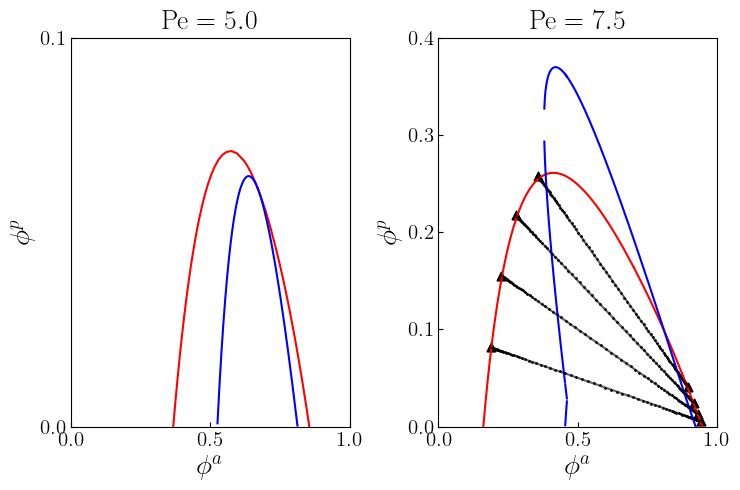

fast load
fast load
fast load
fast load


In [25]:
param_sets[1] = []
for (ax, params) in zip(axs, param_sets)
    ϕas = []
    ϕps = []
    for param in params
        local pde_ts, f_saves, f, t, ϕal, ϕag, ϕpl, ϕpg
        #load saves
        pde_ts, f_saves = load_compress_pde(param)
        f = f_saves[end]
        t = pde_ts[end]

        if t > 500
            rho = f[:,1] + f[:,2] + f[:,3]
            min_pt = argmax(rho)
            max_pt = argmin(rho)
            if min_pt<max_pt
                global x,X
                x = min_pt:1:max_pt
                X = min_pt:(max_pt-min_pt):max_pt
            else
                global x,X 
                x = max_pt:1:min_pt
                X = max_pt:(min_pt-max_pt):min_pt
            end


            ax.plot(f[X,1] + f[X,2], f[X,3], color = "black",linestyle = "-", label = "_gas phase", alpha = 0.5)

            ax.scatter(f[x,1] + f[x,2], f[x,3], color = "black", marker = ".", edgecolor = "black", s = 2, alpha = 1, label = "_gas phase")
            
            ϕal = maximum( f[x,1] + f[x,2])
            ϕag = minimum( f[x,1] + f[x,2])
            ϕpl = minimum( f[x,3] )
            ϕpg = maximum( f[x,3] )
        
            push!(ϕas, ϕal)
            push!(ϕas, ϕag)
            push!(ϕps, ϕpl)
            push!(ϕps, ϕpg)
        end
    end
    ax.scatter(ϕas, ϕps; color = "black", marker = "^", edgecolor = "black")
end
display(fig)


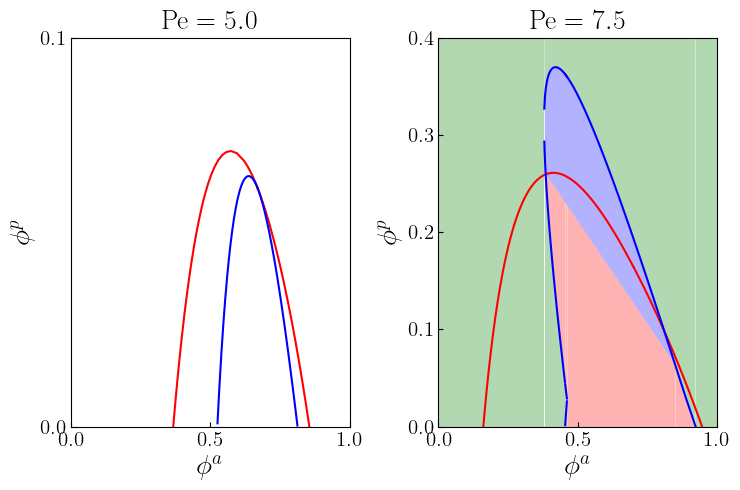

In [145]:
display(fig)
fig_name = "bin_spin_plot"
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_figs/$(fig_name)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_figs/$(fig_name)/bin_spins.pdf";
    PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)


In [30]:

param = param_sets[2][1]
Pe = 7.5
# load binodal
    filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
    data = wload(filename)
    @unpack Pe, γs, ϕ1s, ϕ2s = data
# find final find gamma
    final_γ = 0.
    for (γ, ϕ1, ϕ2) in zip(γs, ϕ1s, ϕ2s)
        if (is_stable_value(gamma_converter(γ, ϕ1)...; Pe = Pe)>0)|(is_stable_value(gamma_converter(γ, ϕ2)...; Pe = Pe)>0)
            final_γ = γ
            break
        end
    end
    final_γ

(Any[0.38, 0.381, 0.382, 0.383, 0.384, 0.385, 0.386, 0.387, 0.388, 0.389  …  0.445, 0.446, 0.447, 0.448, 0.449, 0.45, 0.451, 0.452, 0.453, 0.454], Any[0.38, 0.381, 0.382, 0.383, 0.384, 0.385, 0.386, 0.387, 0.388, 0.389  …  0.914, 0.915, 0.916, 0.917, 0.918, 0.919, 0.92, 0.921, 0.922, 0.923], Any[0.29301807302791627, 0.2835528905649531, 0.2760994819063233, 0.269636091102742, 0.26379218894153433, 0.25838321839315875, 0.2533013985020949, 0.24847729306146224, 0.24386305922221216, 0.23942407355315373  …  0.06843350448236192, 0.06589965413589183, 0.06337472674813355, 0.06085853665390428, 0.05835090487192873, 0.05585165877118447, 0.05336063175836651, 0.05087766298485958, 0.04840259707175184, 0.04593528385154901], Any[0.32689984586929716, 0.33347129674074844, 0.33803205299635913, 0.3416038679902404, 0.34455726834937983, 0.3470768085270717, 0.3492702669119873, 0.3512070771535088, 0.35293507955249437, 0.3544888950012051  …  0.007806132308722457, 0.006962837602991933, 0.006118928571605395, 0.0052

PyObject <matplotlib.collections.PolyCollection object at 0x7fb6f4c0c430>

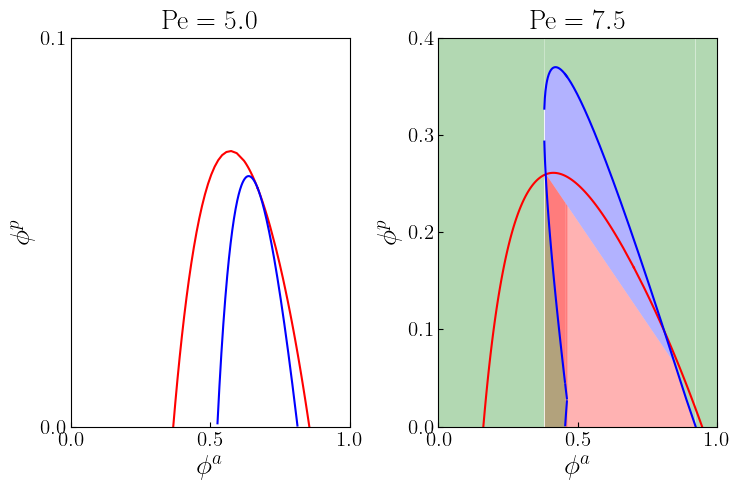

In [148]:
# periodic shading 
ax = axs[2]
ϕas = collect(0.001:0.001:0.999)
    ϕa_low, ϕa_mid, ϕa_high, low_ϕps, mid_ϕps, high_ϕps = return_stable_boundary_extra(ϕas; Pe = Pe)
    kink = maximum(ϕa_mid)
    tie_line = (final_γ-1)*(-ϕa_mid.+1)/final_γ
    ax.fill_between(ϕa_mid, 0*tie_line, low_ϕps, color = "red", alpha = 0.3, linewidth = 0 )
    ax.fill_between(ϕa_mid, mid_ϕps, tie_line, color = "red", alpha = 0.3, linewidth = 0 )
    ax.fill_between(ϕa_mid, low_ϕps, mid_ϕps, color = "green", alpha = 0.3, linewidth = 0 )
ϕas = collect(0.001:0.001:0.999)
ϕa_low, ϕa_high, low_ϕps2, high_ϕps2 = return_stable_boundary(ϕas; Pe = Pe)
    tie_line = (final_γ-1)*(-ϕa_high.+1)/final_γ
    ϕas = [x for (x,y,z) in zip(ϕa_high,high_ϕps2,tie_line) if (y ≥ z )&(x ≥ kink)]
    ax.fill_between(ϕa_high, tie_line, high_ϕps2, high_ϕps2 .> tie_line, color = "blue", alpha = 0.3, linewidth = 0 )
    ax.fill_between(ϕa_high, high_ϕps2, high_ϕps2.+10, color = "green", alpha = 0.3, linewidth = 0 )
    ax.fill_between(ϕa_high, 0*tie_line, min.(tie_line,high_ϕps2),  ϕa_high .≥ kink*ones(length(ϕa_high)), color = "red", alpha = 0.3, linewidth = 0 )
    
    tie_line = (final_γ-1)*(-ϕa_low.+1)/final_γ
    ax.fill_between(ϕa_low, low_ϕps2, tie_line, color = "red", alpha = 0.3, linewidth = 0 )
    ax.fill_between(ϕa_low, 0*low_ϕps2, low_ϕps2, color = "green", alpha = 0.3, linewidth = 0 )
    ax.fill_between([0,minimum(ϕa_low)], [0,0], [10,10], color = "green", alpha = 0.3, linewidth = 0 )
    ax.fill_between([maximum(ϕa_high),1], [0,0], [10,10], color = "green", alpha = 0.3, linewidth = 0 )


    # tie_line = (final_γ-1)*(-ϕas.+1)/final_γ
    # ax.fill_between(ϕas, 0*tie_line, tie_line,  color = "red", alpha = 0.3, linewidth = 0 )
    
display(fig)

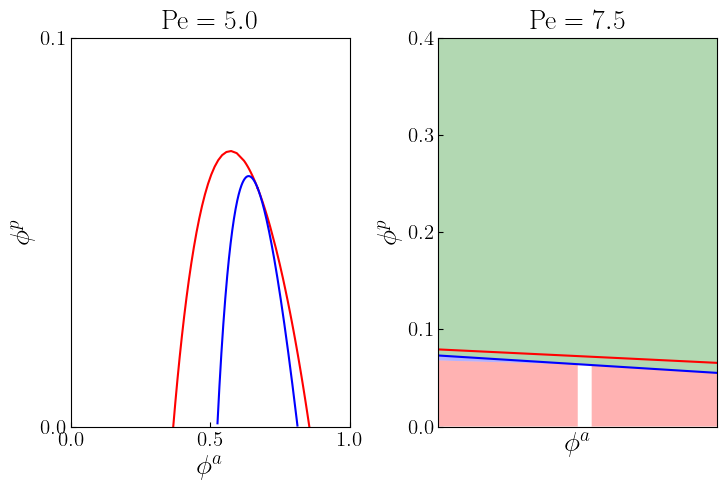

In [135]:
ax.axis([cross-0.01, cross+0.01, 0, 0.4])
display(fig)

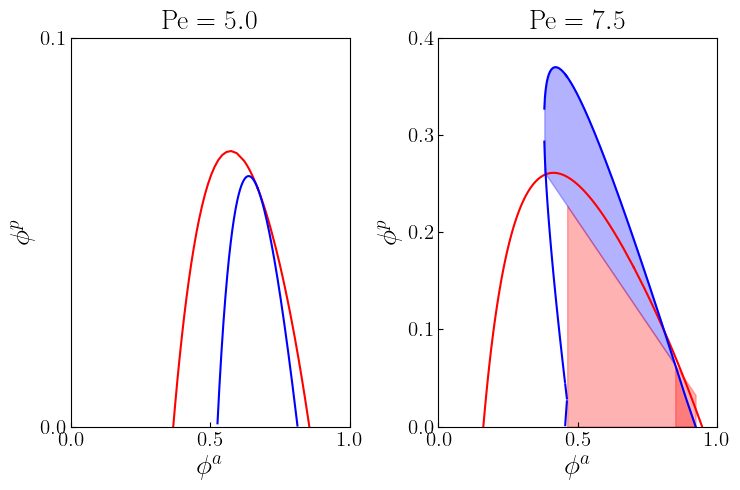

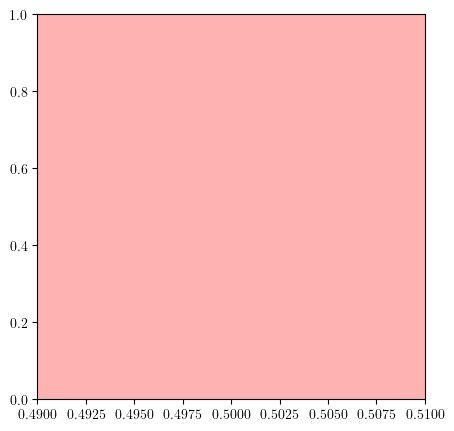

In [138]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

x = 0.01:0.01:1
y1 = zeros(100)
y2 = ones(100)

ax.fill_between(x, y1, y2, x .≥ 0.5 , color = "red", linewidth = 0, alpha = 0.3 )

ax.fill_between(x, y1, y2, x .≤ 0.5 , color = "red", linewidth = 0 , alpha = 0.3)

ax.axis([0.49,0.51, 0,1])
display(fig)
